# Explore for KITTI dataset.

In [61]:
import os
from typing import Callable, List, Optional
from multiprocessing import cpu_count

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.distributed import DistributedSampler

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import re

In [40]:

path2kitti_mask = os.path.expanduser(
    '~/datasets/KITTI/data_road/training/gt_image_2/um_lane_000000.png')
# list_mask = os.listdir(path2kitti_mask)
# test = glob(path2kitti_mask + '/*000000*')


In [91]:
class KITTIRoadDataset(Dataset):
    r"""KITTI Road dataset.
    TODO: separate between train-test split!!
    >>> road_dataset = KITTIRoadDataset('~/datasets/KITTI')
    >>> img, mask = next(iter(road_dataset))
    """
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None) -> None:
        assert isinstance(root, str)

        super().__init__()
        self.root = os.path.expanduser(root)
        self.transform = transform

        BASE_KITTI = 'data_road/training'        
        base_dir = os.path.join(self.root, BASE_KITTI)
        mask_dir = os.path.join(base_dir, 'gt_image_2')
        image_dir = os.path.join(base_dir, 'image_2')
        
        images_dir = os.listdir(image_dir)
        masks_dir = KITTIRoadDataset.get_label_paths(mask_dir)

        self.images = [os.path.join(image_dir, i) for i in images_dir]
        self.masks = [masks_dir[i] for i in images_dir]
        assert len(self.images) == len(self.masks)

    def __getitem__(self, index: int):
        print(self.images[index])
        image = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index], cv2.IMREAD_COLOR)
        # Not need for mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.cvt2mask(mask)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            return image, mask

        else:
            # Refer: Binary DAD-Net
            transform = A.Compose([
                A.Resize(256, 1024),
                A.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)
                ),
                ToTensorV2()
            ])
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            return image, mask

    @staticmethod
    def cvt2mask(mask) -> np.ndarray:
        """Cvt 3-channels mask to binary mask.
        """
        mask = np.all(mask == np.array([0, 0, 255]), axis=2)
        return mask.astype(np.float32)

    @staticmethod
    def get_label_paths(label_pth: str) -> dict:
        """From: https://github.com/adityashrm21/image-segmentation-pytorch/blob/master/torch-model/utils.py
        Get dict of img_pth: label_pth.
        >>> get_label_paths(os.path.expanduser('~/datasets/KITTI/data_road/training/gt_image_2/'))
        """
        label_pths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(label_pth, '*_road_*.png'))}
        return label_pths



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/ninnart/datasets/KITTI/data_road/training/image_2/umm_000077.png
(375, 1242, 3) (375, 1242)
(256, 1024, 3) (256, 1024)


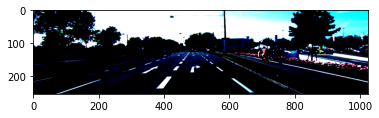

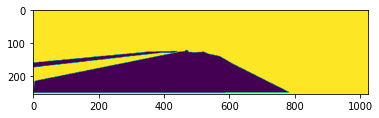

In [93]:
road_dataset = KITTIRoadDataset('~/datasets/KITTI')
img, mask = next(iter(road_dataset))
#img = img.transpose(0, -1)
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()